In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,BatchNormalization,Dropout,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
#Mount your drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
######UTILITY FUNCTIONS##################
"""The function defines which characters you want to detect
:return dict"""
def get_character_dict():
    dict_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
                       3: 'Peter_Griffin'}
    return dict_characters

"""This function loads the trainset for only the set of names given in the dict keys
@:return numpy X ,numpy Y"""
def load_train_set(dirname):
    dict_characters=get_character_dict()
    X_train=[]
    Y_train=[]
    for label,character in dict_characters.items():
        print(label)
        images=os.listdir(dirname+"/"+character)
        for image_names in images:
            image=cv2.imread(dirname+"/"+character+"/"+image_names)
            image=cv2.resize(image,(64,64),interpolation=cv2.INTER_LANCZOS4)
            X_train.append(image)
            Y_train.append(label)
    return np.array(X_train),np.array(Y_train)

"""This function loads the testset 
@:return numpy array"""
def load_test_set(dirname):
    dict_characters=get_character_dict()
    X_test = []
    Y_test = []
    for image_name in sorted(os.listdir(dirname)):
        character_name = "_".join(image_name.split('_')[:-1])
        for label,character in dict_characters.items():
            if(character==character_name):
                image = cv2.imread(dirname + '/' + image_name)
                X_test.append(cv2.resize(image, (64, 64), interpolation=cv2.INTER_LANCZOS4))
                Y_test.append(label)
    return np.array(X_test), np.array(Y_test)

"""The function creates the base model
@:return keras model"""
def create_model():
    model=Sequential()
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding="Same",activation="relu",input_shape=(64,64,3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=86, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(Conv2D(filters=86, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation="softmax"))
    return model


    def create_model_2():
        model=Sequential()
        model.add(Conv2D(filters=32,kernel_size=(3,3),padding="Same",activation="relu",input_shape=(64,64,3)))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                        activation='relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Conv2D(filters=86, kernel_size=(3, 3), padding='Same',
                        activation='relu'))

        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(512, activation="relu"))
        model.add(Dropout(0.5))
        model.add(Dense(4, activation="softmax"))
        return model

"""Prepare the training data with labels and split it into training and validation sets
@:return Xtrain,Ytrain,Xval,Yval """

def prepare_training_data(dirname):
    Xtrain,Ytrain=load_train_set(dirname)
    Xtrain=Xtrain/255.0
    Ytrain= to_categorical(Ytrain, num_classes = 4)
    print(Ytrain.shape)
    return Xtrain,Ytrain

def prepare_testing_data(dirname):
    Xtest, Ytest = load_test_set(dirname)
    Xtest=Xtest/255.0
    Y_test = to_categorical(Ytest, num_classes=4)
    return Xtest,Y_test

"""
Func@3 plot models
@return plots
"""
def plot_history(history):
    # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

def train_save_model(Xtrain,Ytrain,Xtest,Ytest):
    model=create_model()
    model.compile(optimizer=Adam(),loss = "categorical_crossentropy", metrics=["accuracy"])
    model.summary()
    print("Starting training")
    history=model.fit(Xtrain,Ytrain,validation_data=(Xtest,Ytest),epochs=60,batch_size=32,verbose=1)
    model.save("/content/drive/MyDrive/F1_model/model_train_epoch_60.h5")
    plot_history(history)



####Only this functions to be called from the main method#####
def callback_train(traindirname,test_dirname):
    Xtrain,Ytrain=prepare_training_data(traindirname)
    Xtest,Ytest=prepare_testing_data(test_dirname)
    train_save_model(Xtrain,Ytrain,Xtest,Ytest)
    

def callback_check_model_on_single_image(model_path):
    characters=get_character_dict()
    model=load_model(model_path)
    image=cv2.imread("/content/drive/MyDrive/Peter_Griffin_1.jpeg")
    #image=cv2.imread("/content/drive/MyDrive/ECE542_ProjF/SIMPSONS_Data_set/kaggle_simpson_testset/kaggle_simpson_testset/charles_montgomery_burns_1.jpg")
    image_copy=np.copy(image)
    image=cv2.resize(image,(64,64),interpolation=cv2.INTER_LANCZOS4)
    image=image/255.0
    image=np.reshape(image,(-1,64,64,3))
    print("new shape is",image.shape)
    # Xtest, Ytest = prepare_testing_data()
    ypred=model.predict(image)
    print((ypred))
    index_sorted = np.argsort(ypred, axis=1)[0]
    top1_pred = ypred[0][index_sorted][-1]
    top2_pred = ypred[0][index_sorted][-2]
    top3_pred = ypred[0][index_sorted][-3]
    top4_pred=  ypred[0][index_sorted][-4]
    if top1_pred >= 0.5:
        character_name_top1 = characters[index_sorted[-1]]
        character_name_top2 = characters[index_sorted[-2]]
        character_name_top3 = characters[index_sorted[-3]]
        character_name_top4=  characters[index_sorted[-4]]

        Text1 = "%s : %.2f%%" % (character_name_top1.split('_')[0], top1_pred * 100)
        Text2 = "%s : %.2f%%" % (character_name_top2.split('_')[0], top2_pred * 100)
        Text3 = "%s : %.2f%%" % (character_name_top3.split('_')[0], top3_pred * 100)
        Text4=  "%s : %.2f%%" % (character_name_top4.split('_')[0], top4_pred * 100)
        print(Text1)

        cv2.putText(image_copy, Text1, (2, 65), cv2.FONT_HERSHEY_SIMPLEX, 1.7, (0, 0, 0), 3)
        cv2.putText(image_copy,Text2,(2,120),cv2.FONT_HERSHEY_SIMPLEX,1.7,(0, 0, 0),3)
        cv2.putText(image_copy,Text3,(2,220),cv2.FONT_HERSHEY_SIMPLEX,1.7,(0, 0, 0),3)
        cv2.putText(image_copy,Text4,(2,320),cv2.FONT_HERSHEY_SIMPLEX,1.7,(0, 0, 0),3)

        cv2_imshow(image_copy)
       

    print(ypred)

    #See performance with 1 test_data
def callback_evaulate_trained_model(path,testdirname):
    model = load_model(path)
    Xtest,Ytest=prepare_testing_data(testdirname)
    loss,acc=model.evaluate(Xtest,Ytest,verbose=0)
    print("Simpson characters were predicted with a loss of {:.5f} and an accuracy of {:.2f}%".format(loss, acc * 100))

#Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
#Give Path to your train directory over here
Train_Dir='/content/drive/MyDrive/ECE542/Project_F1/Dataset/Train_Data/simpsons_dataset'
Test_Dir='/content/drive/MyDrive/ECE542/Project_F1/Dataset/Test_Data/kaggle_simpson_testset'
Model_Path='/content/drive/MyDrive/model_train_epoch_60.h5'

In [ ]:
os.listdir(Train_Dir)
os.listdir(Test_Dir)

0
1
2
3
(2929, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16

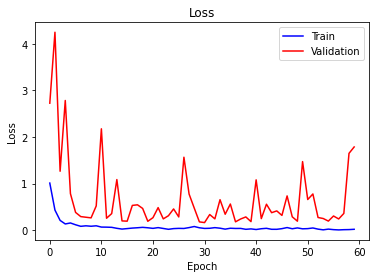

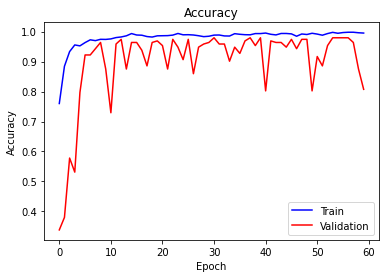

In [ ]:
Training=True
if(Training==True):
    callback_train(Train_Dir,Test_Dir)
else:
    callback_evaulate_trained_model(Model_Path)

new shape is (1, 64, 64, 3)
[[9.1263652e-01 6.3941999e-13 9.1639267e-05 8.7271854e-02]]
Peter : 91.26%


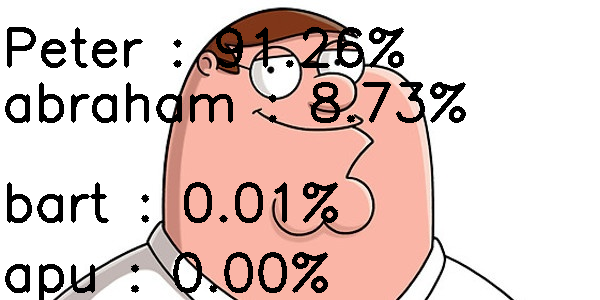

[[9.1263652e-01 6.3941999e-13 9.1639267e-05 8.7271854e-02]]


In [ ]:

callback_check_model_on_single_image(Model_Path)

In [ ]:
callback_evaulate_trained_model(Model_Path,Test_Dir)

Simpson characters were predicted with a loss of 1.78588 and an accuracy of 80.73%


[[8.12646991e-04 6.39623759e-05 9.32317197e-01 6.68062195e-02]
 [1.29174088e-19 2.41102866e-17 1.54715240e-16 1.00000000e+00]
 [7.03038895e-05 2.30398737e-02 9.59530950e-01 1.73588600e-02]
 [1.98320137e-07 1.40857210e-08 9.99999762e-01 2.56444686e-13]
 [3.95805432e-13 1.39456044e-10 2.25775798e-09 1.00000000e+00]
 [1.38504074e-05 5.31987498e-05 6.00474142e-03 9.93928194e-01]
 [6.43341740e-33 0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [1.99909182e-03 8.81797541e-03 9.87917840e-01 1.26506051e-03]
 [3.79529843e-06 8.32533406e-05 1.48877129e-02 9.85025227e-01]
 [1.15665420e-11 9.99754608e-01 2.45346309e-04 1.16441647e-08]
 [2.05799678e-15 1.86558269e-11 7.81303772e-11 1.00000000e+00]
 [6.42392888e-06 1.63829012e-04 3.89286280e-02 9.60901201e-01]
 [1.16612067e-10 1.91800211e-08 1.03961775e-05 9.99989629e-01]
 [1.26097780e-02 7.79995322e-01 2.06266403e-01 1.12848380e-03]
 [1.65117200e-07 4.26603447e-06 1.62956619e-03 9.98366058e-01]
 [4.95111221e-04 1.15956718e-05 8.76721382e-01 1.227719

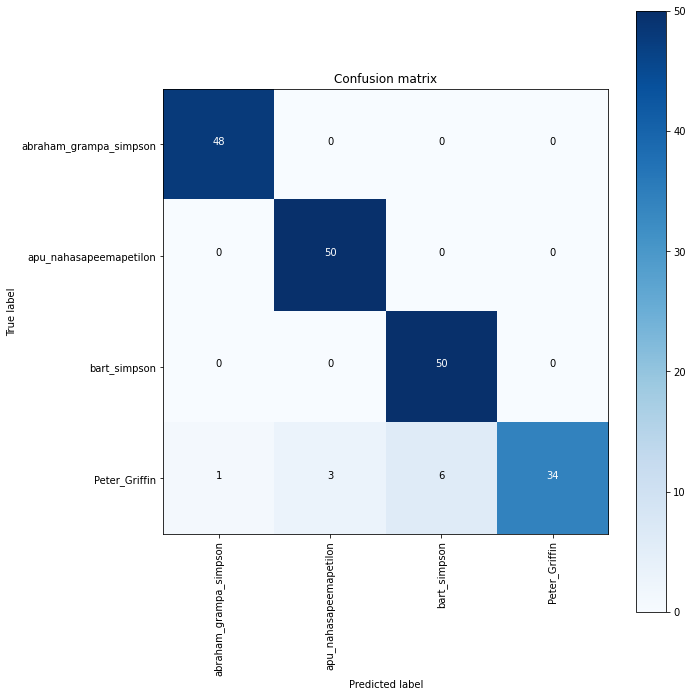

In [ ]:
import itertools
model = load_model(Model_Path)
dict_characters = get_character_dict()
X_test,Y_test=prepare_testing_data(Test_Dir)
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
print(Y_pred)


# Convert hot vectors prediction results to list of classes
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert hot vectors validation observations to list of classes
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
print(classification_report(Y_true,Y_pred_classes))
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 